# GAN to generate Medical Images

## 1. Setup
Importamos las librerías necesarias

In [ ]:
import tensorflow as tf

In [ ]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from skimage.transform import resize
from scipy.linalg import sqrtm
from tensorflow.keras import layers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
import time

from IPython import display

Comprobamos que usamos GPU.

In [ ]:
#device_name = tf.test.gpu_device_name()
#if device_name != '/device:GPU:0':
  #raise SystemError('GPU device not found')
#print('Found GPU at: {}'.format(device_name))

Vinculamos Goggle Drive para poder acceder a las imagenes

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
os.chdir('/content/gdrive/MyDrive/GRUPO 3/Trabajo final')

## 2. Preparación del dataset

Importamos las imágenes y por limitación de recursos computacionales las reducimos a un tamaño de 64x64 con un solo canal (blanco y negro). Además normalizamos las imagenes a [ -1, 1].

In [ ]:
ALTO_IMAGEN = 64
ANCHO_IMAGEN = 64
CANALES = 1
img_folder=r'CXR'

In [ ]:
def create_dataset(img_folder):   
    img_data_array=[]
    for file in sorted(os.listdir(img_folder)):
        image_path = os.path.join(img_folder, file)
        image = np.array(PIL.Image.open(image_path))
        #image = resize(image,(ALTO_IMAGEN,ANCHO_IMAGEN,CANALES),0)
        image.astype('float32')
        img_data_array.append(image)
    img_data_array_new  = [(img - 127.5) / 127.5 for img in img_data_array]
    return img_data_array_new

In [ ]:
train_images = create_dataset(img_folder)

Mostramos la primera imágen.

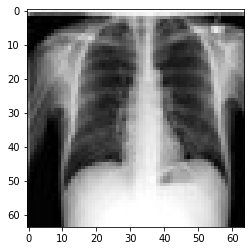

In [ ]:
plt.imshow(train_images[0], cmap = 'gray')

Barajamos el dataset y lo dividimos en batches

In [ ]:
BUFFER_SIZE = len(train_images)    # Número de imagenes totales
BATCH_SIZE = 32        # Número de imagenes por batch
noise_dim = 100

In [ ]:
# Dividir en trozos el array de imágenes y permutar el orden.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3. Crear los modelos

Tanto el generador como el discriminaor se crean usando [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### 3.1 Generador

El generador usa capas `tf.keras.layers.Conv2DTranspose` (upsampling) para producir una imagen a partir de una semilla (ruido aleatorio). Empezamos con una capa `Dense` que toma la semilla como input, ampliando varias veces hasta obtener la imágen deseada de tamaño 64x64x1. Notar el uso de `tf.keras.layers.LeakyReLU` en cada capa excepto la de salida que usa "tanh" como función de activación.

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()

    # 8x8x512
    model.add(layers.Dense(8*8*512, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((8, 8, 512)))

    # 8x8x512 -> 16x16x256
    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # 16x16x256 -> 32x32x128
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 32x32x128 -> 64x64x64
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # 64x64x64 -> 64x64x1
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), padding='same', use_bias=False, activation='tanh'))
    return model

Creamos el generador y mostramos un resumen del modelo

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3276800   
                                                                 
 batch_normalization (BatchN  (None, 32768)            131072    
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      3276800   
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 256)      1

Usamos el generador (aun desentrenado) para crear una imágen.

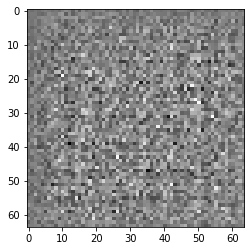

In [ ]:
noise = tf.random.normal([1, noise_dim])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### 3.2 Discriminador

El discriminador es un clasificador de imagenes con arquitectura CNN.

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, kernel_size=5, strides=(2, 2), padding='same', input_shape=[ALTO_IMAGEN,ANCHO_IMAGEN,CANALES]))
    #model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=5,strides=(2, 2), padding = "same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, kernel_size=5,strides=(2, 2), padding = "same"))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dense(1,activation = "sigmoid"))

    return model

**Creamos el discriminador y mostramos un resumen del modelo**

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1664      
                                                                 
 batch_normalization_4 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 batch_normalization_5 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 16, 16, 128)      

Usamos el discriminador (aun desentrenado) para determinar si la imágen anterior es real o generada. El modelo será entrenado para devolver 1 si la imágen es real y 0 si la imágen es generada

In [ ]:
decision = discriminator(generated_image, training = False)
print (decision)

tf.Tensor([[0.5000519]], shape=(1, 1), dtype=float32)


## 4 Funciones de pérdida y optimizadores

Creamos las funciones de pérdida y los optimizadores.


In [ ]:
# Este método devuelve una funcion que ayuda a calcular Binary Cross Entropy
cross_entropy = tf.keras.losses.BinaryCrossentropy()

### 4.1 Pérdida del discriminador

Este método cuantifica como de bien identifica el modelo las imagenes reales de las generadas. Compara las predicciones del modelo de imágenes reales con una lista de 1s y las prediciones de imagenes falsas (generadas) con una lista de 0s.

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output) 
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = (real_loss + fake_loss)/2
    return total_loss

### 4.2 Pérdida del optimizador
La pérdida del generador cuantifica como de bien es capaz de "engañar" al discriminador. Intuitivamente, si el generador está funcionando bien, el discriminador clasificará las imagenes falsas como si fueran reales (o 1s). Aqui, compara la decisión del discriminador de las imagenes generadas con una lista de 1s.

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

### 4.3 Función exactitud

In [ ]:
def accuracy(real_output, fake_output):
    real_acc = tf.math.reduce_sum(real_output)/len(real_output)
    fake_acc = 1 - tf.math.reduce_sum(fake_output)/len(fake_output)
    return real_acc, fake_acc

### 4.4 Optimizadores
El optimizador del generador y del discriminador son diferentes pues entrenaremos cada modelo por separado.

In [ ]:
# Se puede modificar
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Guradando checkpoints

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 5. Entrenamiento


In [ ]:
EPOCHS = 300
num_examples_to_generate = 4

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

El entrenamiento comienza con el generador recibiendo una semilla. Esta semilla es utilizada para genera una imágen. El discriminador es usado para clasificar imágenes reales (tomadas del training set) e imágenes falsas (creadas por el generador). Se calcula la perdida de cada uno de los modelos y los gradientes son utilizados para actualizar el generador y el discriminador.

In [ ]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True) 

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #Calculate loss and accuracy
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        real_acc,fake_acc = accuracy(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return disc_loss, gen_loss, real_acc, fake_acc

In [ ]:
def train(dataset, epochs):
    total_d_loss = []
    total_g_loss = []

    total_real_acc = []
    total_fake_acc = []

    for epoch in range(epochs):
        start = time.time()

        for image_batch in dataset:
            d_loss, g_loss, r_acc, f_acc = train_step(image_batch)
             
            total_d_loss.append(d_loss)
            total_g_loss.append(g_loss)
            total_real_acc.append(r_acc)
            total_fake_acc.append(f_acc)     
        
        # Save the model every 5 epochs
        if (epoch + 1) % 10 == 0 or (epoch + 1) < 20:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
            # Produce images for the GIF as you go
            display.clear_output(wait=True)
            plot_loss(total_d_loss, total_g_loss, epoch + 1)
            generate_and_save_images(generator, epoch + 1, seed)
      
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    average_d_loss = [sum(total_d_loss[i:i+313])/313 for i in range(0,len(total_d_loss),313)]
    average_g_loss = [sum(total_g_loss[i:i+313])/313 for i in range(0,len(total_g_loss),313)]

    average_real_acc = [sum(total_real_acc[i:i+313])/313 for i in range(0,len(total_real_acc),313)]
    average_fake_acc = [sum(total_fake_acc[i:i+313])/313 for i in range(0,len(total_fake_acc),313)]

  # Generate after the final epoch
    display.clear_output(wait=True)
    plot_loss(total_d_loss, total_g_loss, epochs)
    plot_average_loss(average_d_loss,average_g_loss)
    plot_accuracy(average_real_acc,average_fake_acc)
    generate_and_save_images(generator, epochs, seed)

**Funciones auxiliares para generar y guradar imágenes**


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    
    figure, axes = plt.subplots(1,num_examples_to_generate,figsize = (12,3))
    for index, axis in enumerate(axes):
        axis.axis('off')
        axis.imshow(predictions[index, :, :, 0] * 127.5 + 127.5, cmap='gray')
    
    figure.suptitle(f'Images at epoch {epoch}',size = "xx-large")
    plt.savefig(f'./imag_GIF/images_at_epoch_{epoch}.png')
    #plt.title(f"Images at epoch: {epoch}/{EPOCHS}")
    plt.show()

In [ ]:
def plot_loss(d_losses,g_losses,epoch):
    fig, ax = plt.subplots()
    plt.plot(range(1,len(g_losses)+1), g_losses, label='Generator')
    plt.plot(range(1,len(d_losses)+1), d_losses, label='Discriminator')
    plt.title("Losses per iteration")
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'./losses/loss_at_epoch_{epoch}.png')
    plt.show()
    plt.close()  

In [ ]:
def plot_average_loss(d_losses,g_losses):
    fig, ax = plt.subplots()
    plt.plot(range(1,len(g_losses)+1), g_losses, ".-", label='Generator')
    plt.plot(range(1,len(d_losses)+1), d_losses, ".-", label='Discriminator')
    plt.title("Average Losses per epoch")
    plt.xlabel('Epochs')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.savefig('./losses/average_losses.png')
    plt.show()
    plt.close()  

In [ ]:
def plot_accuracy(real_acc,fake_acc):
    fig, ax = plt.subplots()
    plt.plot(range(1,len(real_acc)+1), real_acc, ".-", label='Real Images')
    plt.plot(range(1,len(real_acc)+1), fake_acc, ".-", label='Generated Images')
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Average Accuracy')
    plt.legend()
    plt.savefig('./accuracy/average_accuracy.png')
    plt.show()
    plt.close()

## Entrenar el modelo
Llamamos la función `train()` y entrenamos el generador y discriminador simultaneamente.

Al principio del entrenamiento las imagenes parecerán ruido aleatorio. A medida que progresa empezarán a parecerse más a imágenes reales. Después de unas 30 epocas se parecerán a las imágenes de entrenamiento. Esto puede tardar como un minuto / epoca.

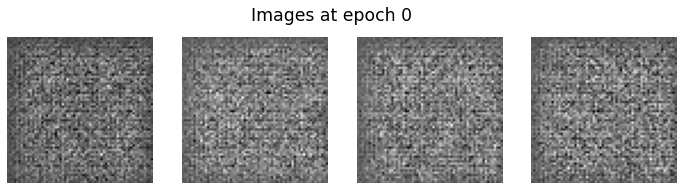

In [ ]:
generate_and_save_images(generator, 0, seed)

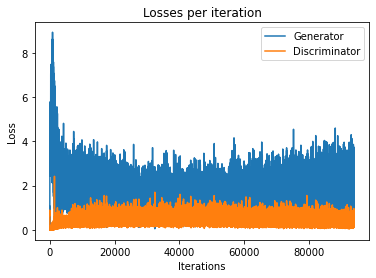

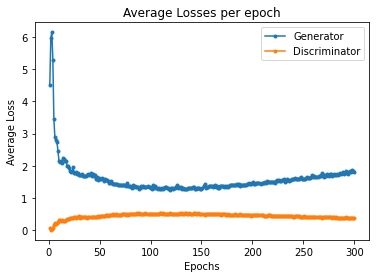

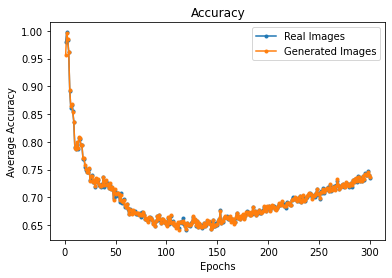

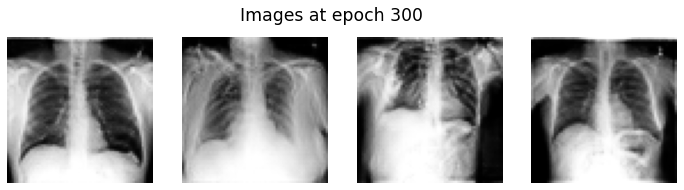

In [ ]:
train(train_dataset, EPOCHS)

Cargamos el último checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## **Creamos un GIF**


In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
    return PIL.Image.open(f'./imag_GIF/images_at_epoch_{epoch_no}.png')

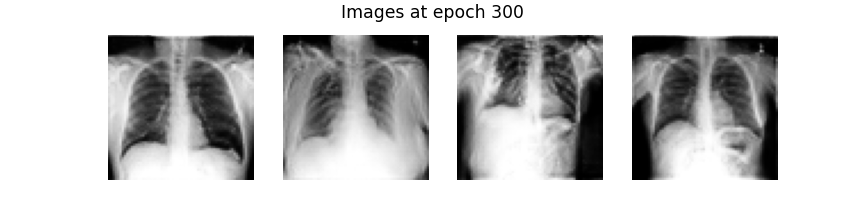

In [ ]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [ ]:
os.chdir('/content/gdrive/MyDrive/GRUPO 3/Trabajo final/imag_GIF')

anim_file = 'Pulmones.gif'

with imageio.get_writer(anim_file, mode='I',fps = 1) as writer:
  filenames = glob.glob('*.png')
  #filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
GIF = PIL.Image.open(anim_file)

#¿Cómo de buenas son nuestras imágenes?
Uno de los métodos mas aceptados para calcular la validez de las imágenes generadas es el FID (Fréchet inception distance) que compara la distribución de las imágenes generadas con la distribución de las imágenes reales que se utilizaron para entrenar al generador.

En lugar de comparar directamente las imágenes píxel a píxel , el FID compara la media y la desviación estándar de una de las capas más profundas de una red neuronal convolucional denominada "Inception v3". Estas capas están más cerca de los nodos de salida  y más lejos de las capas poco profundas cercanas a la imagen de entrada. Como resultado, tienden a imitar la percepción humana de la similitud en las imágenes


Lo primero debemos cambiar el tamaño de nuestras imágenes ya que el modelo "Inception v3" solo acepta imágenes 299x299x3.

In [ ]:
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return np.asarray(images_list)

Descargamos el modelo e implementamos la función FID

In [ ]:
inception_model = InceptionV3(include_top=False, 
                              weights="imagenet", 
                              pooling='avg',
                              input_shape=(299,299,3))

In [ ]:
def calculate_fid(real, generated):
  #calculate activations
  real_embeddings = inception_model.predict(real)
  generated_embeddings = inception_model.predict(generated) 
  
  #calculate mean and covariance statistics
  mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings, rowvar=False)
  mu2, sigma2 = generated_embeddings.mean(axis=0), np.cov(generated_embeddings,  rowvar=False)

  # calculate sum squared difference between means
  ssdiff = np.sum((mu1 - mu2)**2.0)

  # calculate sqrt of product between cov
  covmean = sqrtm(sigma1.dot(sigma2))

  # check and correct imaginary numbers from sqrt
  if np.iscomplexobj(covmean):
      covmean = covmean.real

  # calculate score
  fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
  return fid



Seleccionamos 200 imagenes del dataset de entrenamiento y generamos otras 200.

In [ ]:
np.random.shuffle(train_images)
real_images = [(image+1)/2 for image in train_images[0:200]]
real_images_rgb = [np.stack((image, image, image), axis=2) for image in real_images]

In [ ]:
noise = tf.random.normal([200, noise_dim])
fake_images = np.asarray(generator(noise, training=False))
fake_images_rgb = [np.stack((image, image, image), axis=2) for image in fake_images]

Cálculamos el FID entre las propias imágenes de entrenamiento y entre estas y las generadas. Cuanto más próximo a 0 es el FID, más se asemejan las imágenes.

In [ ]:
# resize images
resized_real = scale_images(real_images_rgb, (299,299,3))
resized_fake = scale_images(fake_images_rgb, (299,299,3))

# pre-process images
resized_real = preprocess_input(resized_real)
resized_fake = preprocess_input(resized_fake)

# fid between resized_real and resized_real
fid = calculate_fid(resized_real[0:100], resized_real[100:200])
print('FID (same): %.3f' % fid)

# fid between resized_real and resized_fake
fid = calculate_fid(resized_real, resized_fake)
print('FID (different) para epoch 300: %.3f' % fid)

In [ ]:
more_fake_images = []
for i in range (8):
  noise = tf.random.normal([256, noise_dim])
  fake_images = np.asarray(generator(noise, training=False))
  fake_images_rgb = [np.stack((image, image, image), axis=2) for image in fake_images]
  resized_fake = scale_images(fake_images_rgb, (299,299,3))
  resized_fake = preprocess_input(resized_fake)
  more_fake_images.extend(resized_fake)

In [ ]:
len(more_fake_images)